<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовим-признаки" data-toc-modified-id="Подготовим-признаки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовим признаки</a></span></li><li><span><a href="#Подготовим-выборки" data-toc-modified-id="Подготовим-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подготовим выборки</a></span></li><li><span><a href="#Обучим-модель-линейной-регрессии" data-toc-modified-id="Обучим-модель-линейной-регрессии-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучим модель линейной регрессии</a></span></li><li><span><a href="#Обучим-модель-решающего-дерева" data-toc-modified-id="Обучим-модель-решающего-дерева-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Обучим модель решающего дерева</a></span></li><li><span><a href="#Обучим-модель-случайного-леса" data-toc-modified-id="Обучим-модель-случайного-леса-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Обучим модель случайного леса</a></span></li><li><span><a href="#Обучим-модель-CatBoost" data-toc-modified-id="Обучим-модель-CatBoost-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Обучим модель CatBoost</a></span></li><li><span><a href="#Обучим-модель-LightGBM" data-toc-modified-id="Обучим-модель-LightGBM-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Обучим модель LightGBM</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

Загрузим наши данные в датафрейм, преобразовав столбец с датой и временем в индекс

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Отсортируем индекс таблицы и проверим, в хронологическом ли порядке расположены даты и время

In [3]:
data.sort_index(inplace=True)
data.index.is_monotonic

True

Ресемплируем данные с интервалом в 1 час

<AxesSubplot:title={'center':'Количество заказов такси'}, xlabel='Дата и время', ylabel='Количество заказов'>

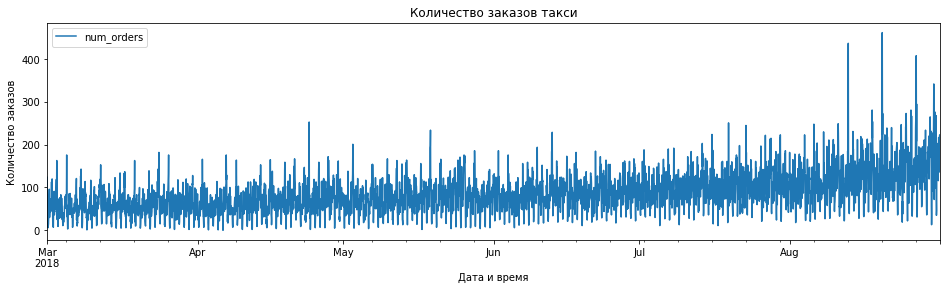

In [4]:
data = data.resample('1H').sum()
plt.figure(figsize=(16,4))
plt.title("Количество заказов такси")
data.plot(ax=plt.gca(), xlabel='Дата и время', ylabel='Количество заказов')

### Вывод

В ходе подготовки данных были присвоены индексы временного ряда, проверен хронологический порядок данных и ресемплированы данные с интервалом в 1 час

## Анализ

Добавим скользящее среднее по одним суткам

<AxesSubplot:title={'center':'Скользящее среднее'}, xlabel='Дата', ylabel='Количество заказов'>

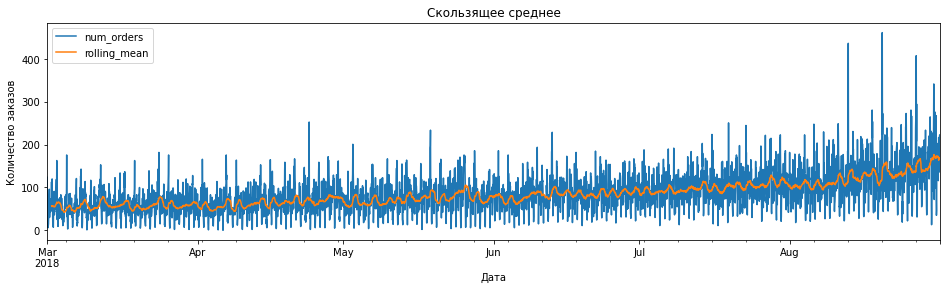

In [5]:
data['rolling_mean'] = data.rolling(24).mean()
plt.figure(figsize=(16,4))
plt.title("Скользящее среднее")
data.plot(ax=plt.gca(), xlabel='Дата', ylabel='Количество заказов')

Можем говорить об устойчивом положительном тренде

Разложим временной ряд на тренд и сезонную компоненту

In [6]:
data = data.drop(['rolling_mean'], axis=1)

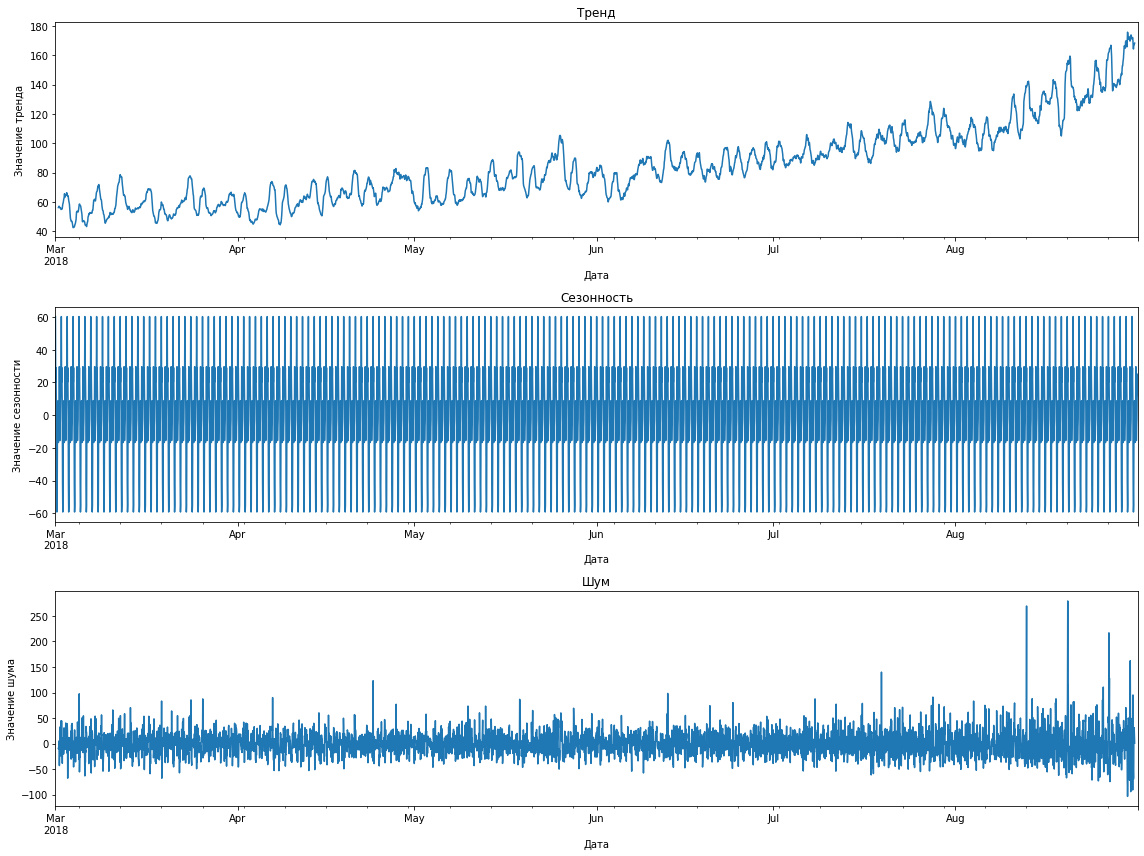

In [7]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(16, 12))
plt.subplot(311)
plt.gca()
decomposed.trend.plot(ax=plt.gca(), xlabel='Дата', ylabel='Значение тренда')
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), xlabel='Дата', ylabel='Значение сезонности')
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), xlabel='Дата', ylabel='Значение шума')
plt.title('Шум')
plt.tight_layout()

Видим тренд на увеличение количества заказов

Шума к концу графика становится больше, значит в тестовую выборку попадет чуть больше данных, которые сложно объяснить и на которых модели будет сложнее предсказывать. Поэтому разница между метриками при обучении и тесте не обязательно будет объясняться только переобучением модели.

Рассмотрим поближе сезонные колебания, возьмем первые 3 дня июня

<AxesSubplot:title={'center':'Сезонность заказов в течение первых 3 дней июня'}, xlabel='Дата и время', ylabel='Значение сезонности'>

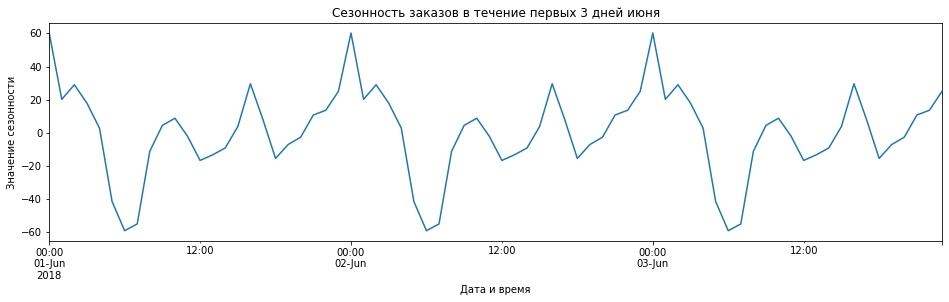

In [8]:
plt.figure(figsize=(16,4))
plt.title("Сезонность заказов в течение первых 3 дней июня")
decomposed.seasonal['2018-06-01':'2018-06-03'].plot(ax=plt.gca(), xlabel='Дата и время', ylabel='Значение сезонности')

Самый большой пик приходится на полночь, спад - на 6 часов утра

Изучим недельную сезонность за первые три недели июня

In [9]:
day_data = data.resample('1D').sum()
decomposed = seasonal_decompose(day_data)

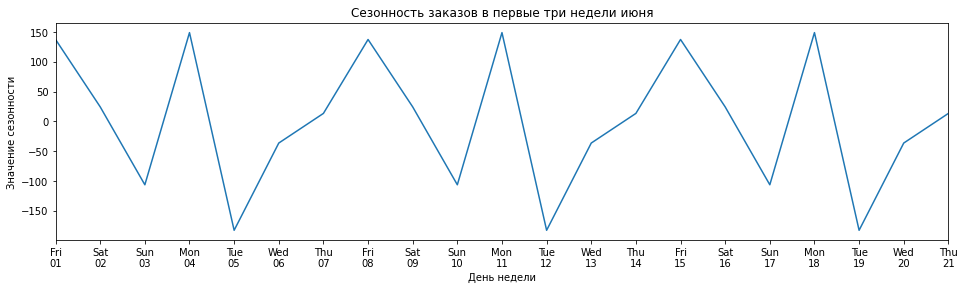

In [10]:
plt.figure(figsize=(16, 4))
plt.title('Сезонность заказов в первые три недели июня')
decomposed.seasonal['2018-06-01':'2018-06-21'].plot(ax=plt.gca(), xlabel='День недели', ylabel='Значение сезонности')
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a\n%d'))

Пики приходятся на понедельник и пятницу, спад - на вторник

### Вывод

В ходе анализа мы выяснили, что имеется тренд на увеличение заказов, а также что количество заказов зависит от времени суток - пик приходится на полночь, спад - на 6 часов утра. Стохастичесский процесс нестационарный, так как у него меняется среднее значение.

In [ ]:
from statsmodels.tsa.stattools import adfuller

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()

ts = taxi['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')


Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


## Обучение

### Подготовим признаки

Напишем фунцкию, которая добавляет признаки

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


Добавим признаки в наш датафрейм

In [13]:
make_features(data, 168, 7)
data.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Подготовим выборки

Разобьем данные на выборки в соотношении 9:1 и удалим NaN'ы

In [14]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [15]:
target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis=1)
target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis=1)

Создадим константную переменную для random_state

In [16]:
RS = 12345

### Обучим модель линейной регрессии

In [17]:
model_lr = LinearRegression()
params = {'fit_intercept' :[True, False]}

grid_lr = RandomizedSearchCV(model_lr,
                             params,
                             n_iter=2,
                             cv=TimeSeriesSplit(),
                             n_jobs=-1,
                             scoring='neg_root_mean_squared_error',
                             random_state=RS)
grid_lr.fit(features_train, target_train)
rmse_lr = abs(grid_lr.best_score_)

print('Лучшие параметры: ', grid_lr.best_params_)
print('RMSE: ', rmse_lr)

Лучшие параметры:  {'fit_intercept': False}
RMSE:  22.748807647711782


### Обучим модель решающего дерева

In [18]:
model_dtr = DecisionTreeRegressor(random_state=RS)
params = {'max_depth': [1, 3, 5, 7, 9],
          'max_features': [2, 3, 4, 5],
          'min_samples_split': [4, 8, 12],
          'min_samples_leaf': [4, 8, 12]
}

grid_dtr = RandomizedSearchCV(model_dtr,
                              params,
                              n_iter=20,
                              cv=TimeSeriesSplit(),
                              n_jobs=-1,
                              scoring='neg_root_mean_squared_error',
                              random_state=RS)
grid_dtr.fit(features_train, target_train)
rmse_dtr = abs(grid_dtr.best_score_)

print('Лучшие параметры: ', grid_dtr.best_params_)
print('RMSE: ', rmse_dtr)

Лучшие параметры:  {'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 5, 'max_depth': 9}
RMSE:  29.239992592226844


### Обучим модель случайного леса

In [19]:
model_rfr = RandomForestRegressor(random_state=RS)
params = {'max_depth': [1, 3, 5, 7, 9, 11, 13, 15],
          'n_estimators': [50, 100, 150, 200, 250, 300],
          'max_features': [2, 4, 6, 8, 10],
          'min_samples_split': [2, 4, 8, 12, 16, 18, 20],
          'min_samples_leaf': [2, 4, 8, 12, 16, 18, 20]
}

grid_rfr = RandomizedSearchCV(model_rfr,
                              params,
                              n_iter=10,
                              cv=TimeSeriesSplit(),
                              n_jobs=-1,
                              scoring='neg_root_mean_squared_error',
                              random_state=RS)
grid_rfr.fit(features_train, target_train)
rmse_rfr = abs(grid_rfr.best_score_)

print('Лучшие параметры: ', grid_rfr.best_params_)
print('RMSE: ', rmse_rfr)

Лучшие параметры:  {'n_estimators': 300, 'min_samples_split': 16, 'min_samples_leaf': 12, 'max_features': 10, 'max_depth': 15}
RMSE:  24.727814032192818


### Обучим модель CatBoost

In [20]:
model_cbr = CatBoostRegressor(verbose=False,
                              random_state=RS)
params = {
    'depth': range(3, 9, 2),
    'iterations': range(500, 1000, 100)
}

grid_cbr = RandomizedSearchCV(estimator=model_cbr,
                              param_distributions=params,
                              n_iter=5,
                              cv=TimeSeriesSplit(),
                              scoring='neg_root_mean_squared_error',
                              n_jobs=-1,
                              random_state=RS
                             )
grid_cbr.fit(features_train, target_train)
rmse_cbr = abs(grid_cbr.best_score_)

print('Лучшие параметры: ', grid_cbr.best_params_)
print('RMSE: ', rmse_cbr)


Лучшие параметры:  {'iterations': 700, 'depth': 5}
RMSE:  22.50337427205271


### Обучим модель LightGBM

In [21]:
model_lgb = lgb.LGBMRegressor(random_state=RS)
params = {
    'max_depth': [3, 5, 7, 9],
    'num_iterations': [500, 600, 700, 800, 900, 1000],
    'learning_rate': [0.001, 0.01, 0.1]
}

grid_lgb = RandomizedSearchCV(estimator=model_lgb,
                              param_distributions=params,
                              n_iter=5,
                              cv=TimeSeriesSplit(),
                              scoring='neg_root_mean_squared_error',
                              n_jobs=-1,
                              random_state=RS
                             )
grid_lgb.fit(features_train, target_train)
rmse_lgb = abs(grid_lgb.best_score_)

print('Лучшие параметры: ', grid_lgb.best_params_)
print('RMSE: ', rmse_lgb)

Лучшие параметры:  {'num_iterations': 800, 'max_depth': 5, 'learning_rate': 0.1}
RMSE:  23.26496727870465


### Вывод

Обучены на тренировочной выборке с кросс-валидацией модели:

- LinearRegression: RMSE ≈ 22,7
- DecisionTreeRegressor: RMSE ≈ 29,2
- RandomForestRegressor: RMSE ≈ 24,7
- CatBoostRegressor: RMSE ≈ 22,5
- LGBMRegressor: RMSE ≈ 23,3

Лучшую метрику показала модель CatBoostRegressor, проверим ее на тестовой выборке

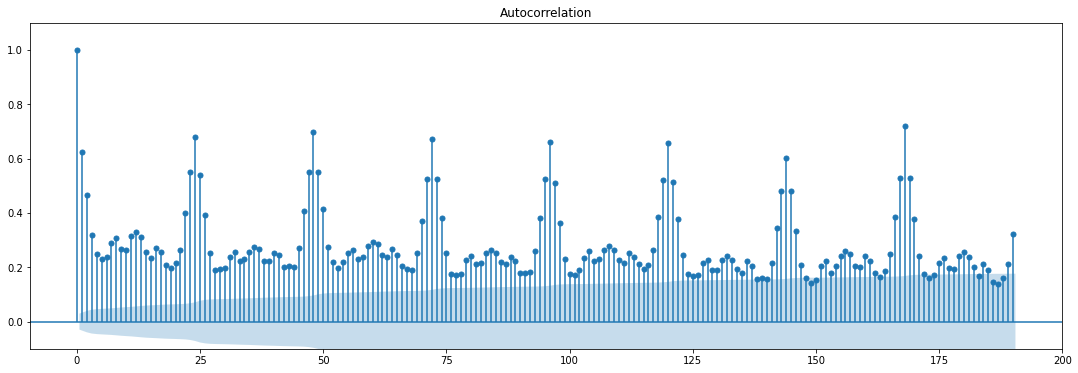

In [ ]:
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 


## Тестирование

In [23]:
best_model = CatBoostRegressor(verbose=False,
                               depth=5,
                               iterations=800,
                               random_state=RS)

best_model.fit(features_train, target_train)
best_predictions = best_model.predict(features_test)
best_rmse = mean_squared_error(target_test, best_predictions)**0.5
print('RMSE на тестовой выборке: ', best_rmse)

RMSE на тестовой выборке:  37.254840833049926


Качество на тесте упало по сравнению с трейном, это может быть связано не только с переобучением модели, но и, как было сказано выше, с увеличением шумов ближе к концу датафрейма

Проверим модель на адекватность

In [25]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
rmse_previous = mean_squared_error(target_test, pred_previous)**0.5
print('RMSE по предыдущему значению: ', rmse_previous)

RMSE по предыдущему значению:  58.856486242815066


Качество модели CatBoost выше, чем качество проверочной модели, значит, модель адекватна

## Вывод

В ходе подготовки данных были присвоены индексы временного ряда, проверен хронологический порядок данных и ресемплированы данные с интервалом в 1 час

В ходе анализа мы выяснили, что имеется тренд на увеличение заказов, а также что количество заказов зависит от времени суток - пик приходится на полночь, спад - на 6 часов утра. Стохастичесский процесс нестационарный, так как у него меняется среднее значение.

Обучены на тренировочной выборке с кросс-валидацией модели:

- LinearRegression: RMSE ≈ 22,7
- DecisionTreeRegressor: RMSE ≈ 29,2
- RandomForestRegressor: RMSE ≈ 24,7
- CatBoostRegressor: RMSE ≈ 22,5
- LGBMRegressor: RMSE ≈ 23,3

Лучшую метрику показала модель CatBoostRegressor, проверили ее на тестовой выборке. Результат: RMSE ≈ 37,3

Эта модель успешно прошла проверку на адекватность